In [1]:
import requests, pandas as pd, matplotlib.pyplot as plt
import numpy as np
from ipywidgets import SelectMultiple, interact, Dropdown
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import warnings
from collections import Counter

In [2]:
# kubectl port-forward svc/router 8888:80 -n fission
BASE_URL = "http://127.0.0.1:8888/data-filter"

In [3]:
def post_processing(payload):
    resp = requests.post(BASE_URL, json=payload, timeout=120)
    resp.raise_for_status()
    
    data = resp.json()
    print("Total hits:", data["total"])
    
    docs = resp.json()["data"]
    records = []
    for d in docs:
        record = {
            "sentiment": d.get("sentiment"),
            "platform": d.get("platform"),
            "_id": d.get("_id"),
            "sentimentLabel": d.get("sentimentLabel"),
            "keywords": d.get("keywords"),
            "tags": d.get("data", {}).get("tags"),
            "createdAt": d.get("data", {}).get("createdAt"),
        }
        records.append(record)
    df = pd.DataFrame(records)
    
    df["createdAt"] = df["createdAt"].str.replace(r"Z$", "", regex=True)
    df["createdAt"] = pd.to_datetime(
        df["createdAt"],
        utc=True,
        errors="raise",
        format="ISO8601"
    )
    
    df["month"] = (
        df["createdAt"]
          .dt.tz_convert(None)
          .dt.to_period("M")
    )
    
    return df

In [ ]:
cost_living_payload = {
    "content": ["afl*", "AFL"],   # data.content
    "tags":     ["afl", "AFL"],   # data.tags
    "keywords": ["afl", "AFL"],   # data.keywords
    "combine":  "or",      # and OR or
    "size":     10000,
    "max_docs": 500000,    # max get data
    "date_range": {
        "from": "01-01-2000",
        "to":   "31-12-2026"
    }
}

df = post_processing(cost_living_payload)
df

Total hits: 356815


,sentiment,platform,_id,sentimentLabel,keywords,tags,createdAt,month
0,0.8920,Mastodon,mastodon_114505074741619487,positive,"[willpower, play, wow, hour, boring]",[],2025-05-14 07:46:21+00:00,2025-05
1,0.1901,Mastodon,mastodon_114505072319548213,positive,"[yoy, appfigures, bloomberg, https, articles]",[],2025-05-14 07:45:43+00:00,2025-05
2,0.8313,Mastodon,mastodon_114505071372449264,positive,"[graduates, articles, family, history, time.ht...",[],2025-05-14 07:45:27+00:00,2025-05
3,-0.1739,Mastodon,mastodon_114505050397788320,negative,"[insurance, reopening, clubs, clear, road]",[],2025-05-14 07:40:06+00:00,2025-05
4,0.0000,Mastodon,mastodon_114505047728689717,neutral,"[nsfwverifiedamateurs, nsfw, guy, auroraberrie...","[u_auroraberries, r_nsfwverifiedamateurs, auro...",2025-05-14 07:39:20+00:00,2025-05
...,...,...,...,...,...,...,...,...
356810,-0.4767,Reddit,reddit_6vrus,negative,"[shame, replacing, match, afl, olympic]",[australia],2008-08-11 07:08:03+00:00,2008-08
356811,0.3182,Reddit,reddit_6vr43,positive,"[woolworths, price, potatoes, increase, threef...",[australia],2008-08-11 03:20:09+00:00,2008-08
356812,0.1531,Reddit,reddit_6soox,positive,"[begin, afl, nrl, football, wars]",[australia],2008-07-21 04:15:48+00:00,2008-07
356813,-0.2960,Reddit,reddit_6g29x,negative,"[queensland, boob, nose, jobs, teens]",[australia],2008-04-17 02:15:34+00:00,2008-04


In [ ]:
afl_teams_aliases = {
    "Adelaide Crows": ["Adelaide", "Crows", "The Crows", "Ades"],
    "Brisbane Lions": ["Brisbane", "Lions", "Brissie", "The Lions"],
    "Carlton": ["Carlton", "Blues", "The Blues"],
    "Collingwood Magpies": ["Collingwood", "Magpies", "Pies", "The Pies"],
    "Essendon Bombers": ["Essendon", "Bombers", "Dons", "The Bombers"],
    "Fremantle Dockers": ["Fremantle", "Dockers", "Freo", "The Dockers"],
    "Geelong Cats": ["Geelong", "Cats", "The Cats"],
    "Gold Coast Suns": ["Gold Coast", "Suns", "The Suns"],
    "GWS Giants": ["GWS", "Giants", "Greater Western Sydney", "The Giants"],
    "Hawthorn Hawks": ["Hawthorn", "Hawks", "The Hawks"],
    "Melbourne Demons": ["Melbourne", "Demons", "Dees", "The Demons"],
    "North Melbourne Kangaroos": ["North Melbourne", "Kangaroos", "Roos", "The Roos"],
    "Port Adelaide Power": ["Port Adelaide", "Power", "The Power", "Port"],
    "Richmond Tigers": ["Richmond", "Tigers", "The Tigers"],
    "St Kilda Saints": ["St Kilda", "Saints", "The Saints"],
    "Sydney Swans": ["Sydney", "Swans", "The Swans"],
    "West Coast Eagles": ["West Coast", "Eagles", "The Eagles"],
    "Western Bulldogs": ["Western Bulldogs", "Bulldogs", "Doggies", "The Bulldogs"]
}
def detect_afl_teams(row):
    tags = row.get("tags", [])
    keywords = row.get("keywords", [])
 
    if isinstance(tags, str):
        tags = [tags]
    if isinstance(keywords, str):
        keywords = [keywords]
    
    combined = [str(x).lower() for x in tags + keywords]
    matched_teams = []

    for team, aliases in afl_teams_aliases.items():
        for alias in aliases:
            if alias.lower() in combined:
                matched_teams.append(team)
                break  
    
    return matched_teams if matched_teams else np.nan

df["matched_teams"] = df.apply(detect_afl_teams, axis=1)

df = df[df["matched_teams"].notnull()]

In [23]:
df

,sentiment,platform,_id,sentimentLabel,keywords,tags,createdAt,month,matched_teams
11,0.4501,Bluesky,bluesky_3lp4ic75si22r,positive,"[hoodoo, match-up, youtu.be, aflswansblues, scg]",[sydney],2025-05-14 07:33:22.200000+00:00,2025-05,[Sydney Swans]
18,-0.2911,Mastodon,mastodon_114505010694129986,negative,"[magpies, footy, lemmy.ml, afl, schultz]","[afl, footy]",2025-05-14 07:30:04+00:00,2025-05,[Collingwood Magpies]
23,0.0000,Bluesky,bluesky_3lp4hwklpnc2d,neutral,"[month, aussie, based, authors, bookish]",[sydney],2025-05-14 07:26:51.531000+00:00,2025-05,[Sydney Swans]
27,0.7650,Bluesky,bluesky_3lp4hsdae4s2u,positive,"[places, australia, good, find, sydney]",[sydney],2025-05-14 07:24:29.606000+00:00,2025-05,[Sydney Swans]
49,0.9192,Reddit,reddit_1km8yju,positive,"[suggestions, melbourne, courier, service, trial]",[],2025-05-14 07:07:20+00:00,2025-05,[Melbourne Demons]
...,...,...,...,...,...,...,...,...,...
356787,0.0000,Reddit,reddit_82k9m,neutral,"[melbourne, tremor, live, imagining, things]",[australia],2009-03-06 10:04:53+00:00,2009-03,[Melbourne Demons]
356797,-0.5994,Reddit,reddit_7rrd4,negative,"[melbourne, phoenix, a-league, victory, wellin...",[australia],2009-01-23 00:10:45+00:00,2009-01,[Melbourne Demons]
356802,-0.5209,Reddit,reddit_7e3t6,negative,"[aussies, brisbane, natural, disaster, zone]",[australia],2008-11-18 14:01:58+00:00,2008-11,[Brisbane Lions]
356809,-0.4939,Reddit,reddit_70arz,negative,"[arrogant, sydney, afl, kick, goals]",[australia],2008-09-08 16:09:17+00:00,2008-09,[Sydney Swans]


In [ ]:
from collections import defaultdict

team_sentiment = defaultdict(lambda: {"positive": 0, "neutral": 0, "negative": 0})

for _, row in df.iterrows():
    sentiment = str(row["sentimentLabel"]).lower()
    teams = row.get("matched_teams", [])

    if isinstance(teams, str):
        teams = [teams]

    for team in teams:
        if sentiment in team_sentiment[team]:
            team_sentiment[team][sentiment] += 1

print("\n=== AFL Team Sentiment Summary ===")
for team, counts in sorted(team_sentiment.items()):
    print(f"{team} - Positive: {counts['positive']} | Neutral: {counts['neutral']} | Negative: {counts['negative']}")




=== AFL Team Sentiment Summary ===
Adelaide Crows - Positive: 12461 | Neutral: 2709 | Negative: 4492
Brisbane Lions - Positive: 2770 | Neutral: 1323 | Negative: 1073
Carlton - Positive: 1205 | Neutral: 1185 | Negative: 908
Collingwood Magpies - Positive: 1643 | Neutral: 1445 | Negative: 1118
Essendon Bombers - Positive: 1226 | Neutral: 1255 | Negative: 890
Fremantle Dockers - Positive: 1216 | Neutral: 1381 | Negative: 893
GWS Giants - Positive: 951 | Neutral: 884 | Negative: 633
Geelong Cats - Positive: 1478 | Neutral: 1072 | Negative: 862
Gold Coast Suns - Positive: 475 | Neutral: 466 | Negative: 225
Hawthorn Hawks - Positive: 1268 | Neutral: 1164 | Negative: 807
Melbourne Demons - Positive: 4670 | Neutral: 1955 | Negative: 1667
North Melbourne Kangaroos - Positive: 290 | Neutral: 210 | Negative: 127
Port Adelaide Power - Positive: 1755 | Neutral: 1077 | Negative: 966
Richmond Tigers - Positive: 1298 | Neutral: 1216 | Negative: 840
St Kilda Saints - Positive: 400 | Neutral: 386 | Neg

# Cost Living

In [90]:
cost_living_payload = {
    "content": [
        "cost", "rent", "price", "grocery", "transport", "bill", "living", "wage", "income", "expensive",
        "afford", "renting", "apartment", "real estate", "landlord", "tenant", "lease", "mortgage", "housing",
        "electricity", "gas", "water", "utility", "power bill", "food", "meal", "dining", "supermarket", "shopping",
        "financial", "budget", "ripoff", "overpriced", "cheapest", "cheaper", "cheap", "struggle", "student loan",
        "university", "school", "tuition", "doctor", "hospital", "medicare", "insurance", "healthcare", "uber", "loan",
        "fee", "fees", "wws", "woolworths", "aldi", "coles", "buy", "pay", "myki", "PTV", "metro",
        "taxi", "public transport", "car", "petrol", "fuel"],
    "tags":     [],
    "keywords": ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"],
    "combine":  "and",
    "size":     10000,
    "max_docs": 500000,
    "date_range": {
        "from": "01-01-2023",
        "to":   "31-12-2026"
    }
}

resp = requests.post(BASE_URL, json=cost_living_payload, timeout=120)
resp.raise_for_status()

data = resp.json()
print("Total hits:", data["total"])

cities = ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"]
docs = resp.json()["data"]
records = []
for d in docs:
    keywords = d.get("keywords", [])
    matched_cities = [k for k in keywords if k in cities]

    sentiment = d.get("sentiment")
    platform = d.get("platform")
    _id = d.get("_id")
    sentimentLabel = d.get("sentimentLabel")
    tags = d.get("data", {}).get("tags")
    createdAt = d.get("data", {}).get("createdAt")

    for city in matched_cities:
        records.append({
            "city": city,
            "sentiment": sentiment,
            "platform": platform,
            "_id": _id,
            "sentimentLabel": sentimentLabel,
            "keywords": keywords,
            "tags": tags,
            "createdAt": createdAt
        })

# 创建 DataFrame
df = pd.DataFrame(records)

# 时间字段处理
df["createdAt"] = df["createdAt"].str.replace(r"Z$", "", regex=True)
df["createdAt"] = pd.to_datetime(df["createdAt"], utc=True, errors="raise", format="ISO8601")
df["month"] = df["createdAt"].dt.tz_convert(None).dt.to_period("M")


# functions 1
def show_avg_by_city():
    cities = ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"]
    df_exp = df.explode("keywords")
    df_cities = df_exp[df_exp["keywords"].isin(cities)]
    avg_sent = (
        df_cities
        .groupby("keywords")["sentiment"]
        .mean()
        .reindex(cities)
        .sort_values(ascending=False)
    )
    
    plt.figure(figsize=(8, 5))
    avg_sent.plot(kind="bar", edgecolor="k")
    plt.title("Average Sentiment by City Keyword")
    plt.xlabel("City")
    plt.ylabel("Average Sentiment")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# function 2
def interact_city_month():
    df_tags = df.explode("keywords").copy()
    df_tags["keywords_lower"] = df_tags["keywords"].astype(str).str.lower()
    
    cities = ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"]
    city1_dd = Dropdown(options=cities, value='brisbane', description='City 1:')
    city2_dd = Dropdown(options=cities, value='melbourne', description='City 2:')
    
    @interact(city1=city1_dd, city2=city2_dd)
    def plot_two(city1, city2):
        if city1 == city2:
            print("Please Select two different cities")
            return
    
        df_city_1  = df_tags[df_tags["keywords_lower"] == city1]
        df_city_2  = df_tags[df_tags["keywords_lower"] == city2]
    
        city_monthly_1 = (
            df_city_1
            .groupby("month")["sentiment"]
            .mean()
            .reset_index(name="avg_sentiment")
            .rename(columns={'avg_sentiment': city1})
        )
        city_monthly_2 = (
            df_city_2
            .groupby("month")["sentiment"]
            .mean()
            .reset_index(name="avg_sentiment")
            .rename(columns={'avg_sentiment': city2})
        )
    
        df_plot = (
            city_monthly_1
            .merge(city_monthly_2, on='month', how='outer')
            .sort_values('month')
            .reset_index(drop=True)
        )
    
        x     = np.arange(len(df_plot))
        width = 0.35
    
        fig, ax = plt.subplots(figsize=(9, 4))
        ax.bar(x - width/2, df_plot[city1],  width, label=city1)
        ax.bar(x + width/2, df_plot[city2],  width, label=city2)
    
        ax.set_xlabel('Month')
        ax.set_ylabel('Average sentiment')
        ax.set_title('Monthly average sentiment by city')
        ax.set_xticks(x)
        ax.set_xticklabels(df_plot['month'].astype(str), rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()

# function 3
def key_cloud():
    all_kw = df["keywords"].explode().astype(str).str.lower()
    freq = all_kw.value_counts().to_dict()
    custom_stop = {
        "brisbane","melbourne","sydney","perth","adelaide",
        "removed","deleted","remove",
        "day","week","month","year","today","time",
        "good","people","things","work","living","buy","move",
        "hey","nt","n’t","ve","ll",
        "north","south","east","west", "australia"
    }
    stopwords = set(STOPWORDS) | custom_stop
    freq = {w:c for w,c in freq.items() if w not in stopwords}
    
    wc = WordCloud(
        width=800, height=400,
        background_color="white",
        max_words=150,
        collocations=False
    ).generate_from_frequencies(freq)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Function 4: The distribution of Average Sentiment among Cities in Different Years
def show_violin_city_by_time():
    # Hide warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Select the time range
    def plot_sentiment(time_range):
        ranges = {
            "2023-2024": (df["createdAt"] >= pd.Timestamp("2023-01-01", tz="UTC")) & 
                        (df["createdAt"] < pd.Timestamp("2024-01-01", tz="UTC")),
            "2024–2025": (df["createdAt"] >= pd.Timestamp("2024-01-01", tz="UTC")) & 
                        (df["createdAt"] < pd.Timestamp("2025-01-01", tz="UTC")),
            "2025-Now": df["createdAt"] >= pd.Timestamp("2025-01-01", tz="UTC"),
            "All Time": slice(None)
        }
        mask = ranges[time_range]
        filtered = df[mask] if isinstance(mask, pd.Series) else df.copy()

        # Consider if there's no data
        if filtered.empty:
            print("No data in this time range.")
            return

        # Calculate the average sentiment
        avg = filtered.groupby("city")["sentiment"].mean().sort_values(ascending=False).reset_index()
        city_order = avg["city"]

        # Plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=filtered, x="city", y="sentiment", order=city_order, palette="viridis", inner=None)
        sns.scatterplot(data=avg, x="city", y="sentiment", color="white", s=100, zorder=10)
        plt.plot(range(len(avg)), avg["sentiment"], color="black", linewidth=1.5, zorder=9)
        plt.ylim(-1, 1)
        plt.title(f"Average Sentiment Distribution by City ({time_range})")
        plt.xticks(rotation=45)
        plt.ylabel("Sentiment Score")
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Hide the notice
    _ = interact(
        plot_sentiment,
        time_range=["All Time", "2023-2024", "2024–2025", "2025-Now"]
    )
    return

# Function 5: The distribution of Sentiment by Platforms
def sentimentByPlatform():
    plt.figure(figsize=(8, 6))
    
    sns.boxplot(
        data=df,
        x="platform",
        y="sentiment",
        palette="pastel",
        linewidth=2.0,
        fliersize=3
    )
    plt.title("Sentiment Distribution by Social Media Platform", fontsize=14, fontweight="bold")
    plt.xlabel("Platform", fontsize=12)
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.ylim(-1.05, 1.05)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return

# Function 6: Relation between City & Platform
def heatMap():
    pivot = (
        df.groupby(["city", "platform"])
        .size()
        # Set missing values as 0
        .unstack(fill_value=0)
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        pivot,
        annot=True,
        fmt="d",
        cmap="YlGnBu"
    )
    plt.title("Relation between City & Platform", fontsize=14, fontweight="bold")
    plt.xlabel("Platform", fontsize=12)
    plt.ylabel("City", fontsize=12)
    plt.tight_layout()
    plt.show()
    return

# Function 7: The top 30 keywords in posts with extreme sentiments [Discard the keywords in common!]
def extremeKeywords():
    # Select from Top & Bottom 100 posts
    top_100 = df.nlargest(100, "sentiment")
    bottom_100 = df.nsmallest(100, "sentiment")

    field = "keywords"
    top_keywords_all = [k for kws in top_100[field] for k in kws]
    bottom_keywords_all = [k for kws in bottom_100[field] for k in kws]
    top_counts = Counter(top_keywords_all)
    bottom_counts = Counter(bottom_keywords_all)

    # Discard the repeated words
    overlap = set(top_counts.keys()) & set(bottom_counts.keys())
    for k in overlap:
        del top_counts[k]
        del bottom_counts[k]

    top_keywords = [k for k, _ in top_counts.most_common(30)]
    bottom_keywords = [k for k, _ in bottom_counts.most_common(30)]

    # Fill in blanks if <30
    max_len = max(len(top_keywords), len(bottom_keywords))
    top_keywords += [""] * (max_len - len(top_keywords))
    bottom_keywords += [""] * (max_len - len(bottom_keywords))

    # Create DataFrame with index 1~30
    extreme_keywords_df = pd.DataFrame({
        "Top 30 Sentiment Keywords": top_keywords,
        "Bottom 30 Sentiment Keywords": bottom_keywords
    }, index=range(1, max_len + 1))

    return extreme_keywords_df

# Function 8: The Trend of the Average Sentiment
def sentimentTrend():
    df_biweekly = df.copy()
    df_biweekly["createdAt"] = pd.to_datetime(df_biweekly["createdAt"])
    
    # Set frequency as 2-weeks
    biweekly_avg = (
        df_biweekly
        .set_index("createdAt")
        .resample("2W")["sentiment"]
        .mean()
        .dropna()
    )

    # Plot
    biweekly_avg.plot(
        figsize=(12, 5),
        title="Trend of Average Sentiment"
    )
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    return

Total hits: 13111


In [94]:
show_violin_city_by_time()

interactive(children=(Dropdown(description='time_range', options=('All Time', '2023-2024', '2024–2025', '2025-…

In [92]:
interact_city_month()

interactive(children=(Dropdown(description='City 1:', options=('brisbane', 'melbourne', 'sydney', 'canberra', …

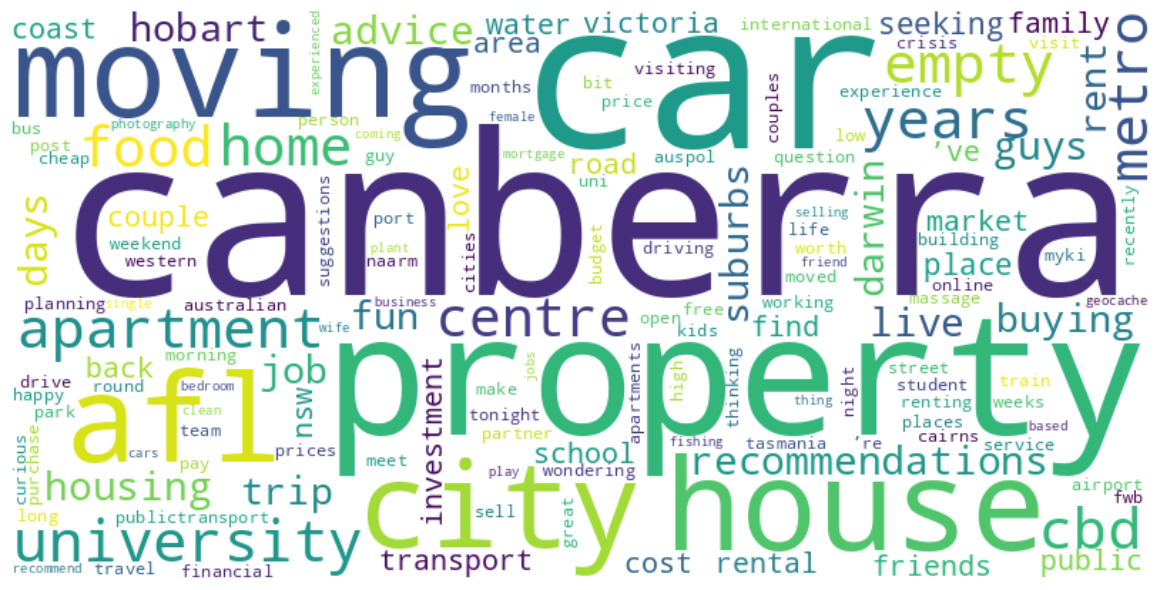

In [93]:
key_cloud()

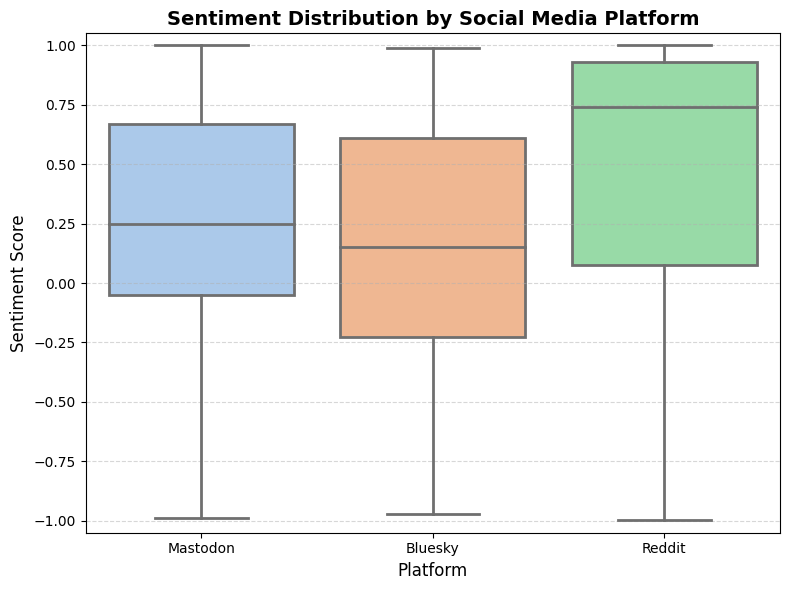

In [95]:
sentimentByPlatform()

In [97]:
extremeKeywords()

,Top 30 Sentiment Keywords,Bottom 30 Sentiment Keywords
1,time,police
2,enjoy,car
3,love,man
4,things,daniher
5,person,forward
6,online,darwin
7,interested,street
8,seeking,hills
9,coast,crime
10,friends,australian


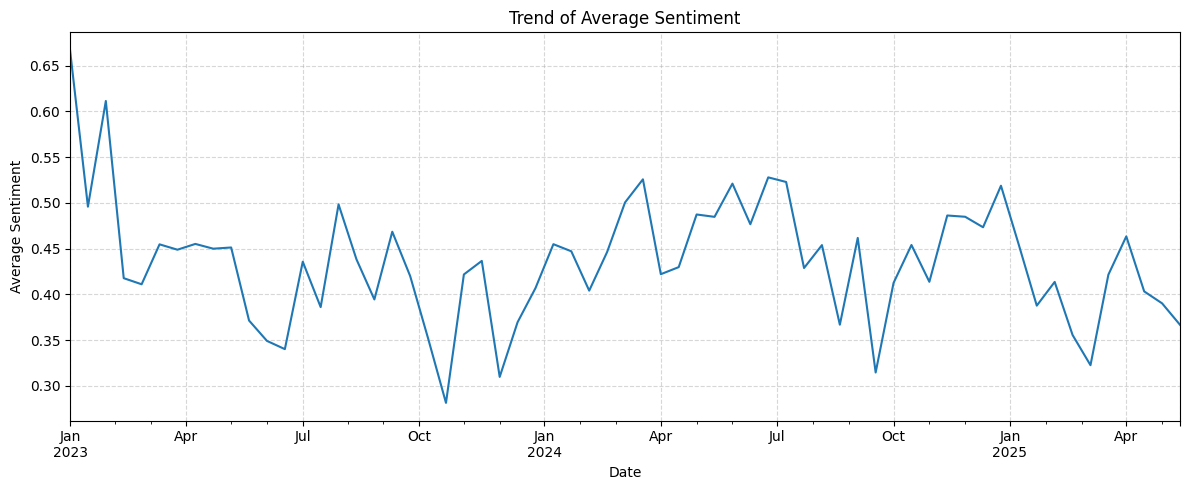

In [98]:
sentimentTrend()

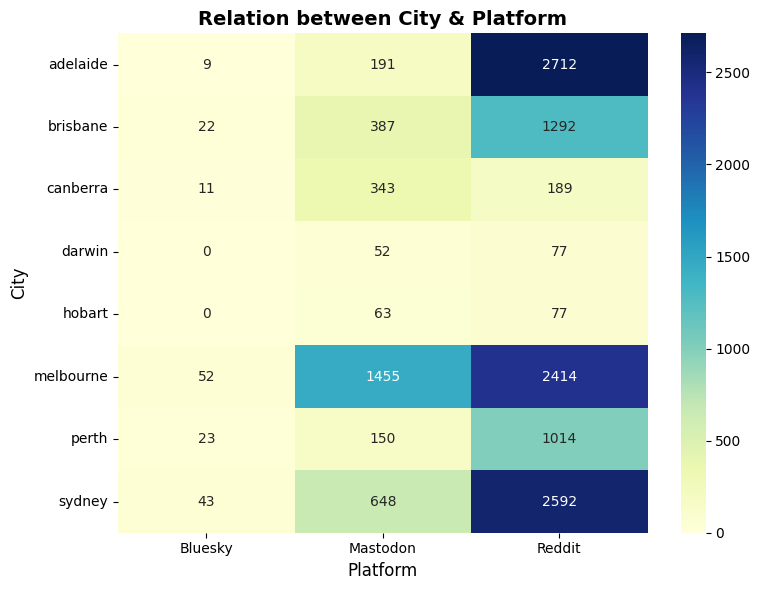

In [96]:
heatMap()